<a href="https://colab.research.google.com/github/Joovvhan/ColabTest/blob/master/notebooks/eumun_to_eumjul_network_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import copy
import matplotlib.pyplot as plt
import random

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [22]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/eumjul_eumun_pairs.npy'

pairs = np.load(data_path)

In [24]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
# unicode_jamo_list += [' ', '!', ',', '.', '?', '<eos>']
    
unicode_jamo_list.sort()

# unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

tokenized_pair = [[tokenizer.word2num(list(pairs[i, 0]) + ['<eos>']), tokenizer.word2num(list(pairs[i, 1]) + ['<eos>'])] for i in range(len(pairs))]

In [27]:
idxs = range(0, len(tokenized_pair))

train_size = int(0.8 * len(tokenized_pair))

train_idxs = set(np.random.choice(idxs, train_size, False))

total_idxs_set = set(idxs)

eval_idxs = list(total_idxs_set - train_idxs)

train_idxs = list(train_idxs)

train_pairs = [tokenized_pair[idx] for idx in train_idxs]
eval_pairs = [tokenized_pair[idx] for idx in eval_idxs]

print("Size of the total pairs: {}".format(len(tokenized_pair)))
print("Size of the training pairs: {}".format(len(train_pairs)))
print("Size of the evaluation pairs: {}".format(len(eval_pairs)))

Size of the total pairs: 51955
Size of the training pairs: 41564
Size of the evaluation pairs: 10391


In [0]:
def ordered_shuffling(pairs, shuffle_step = 12):
    eumun_length_list = np.asarray([len(pair[1]) for pair in pairs])
    
#   print(eumun_length_list)
    
    sorted_order = np.argsort(eumun_length_list)
    
    bundle = np.stack([eumun_length_list[sorted_order], sorted_order])

    for seq_len in range(shuffle_step, np.max(eumun_length_list), shuffle_step):
        idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + shuffle_step))[0]
        idxs_origin = copy.deepcopy(idxs)
        random.shuffle(idxs)
        bundle[:, idxs_origin] = bundle[:, idxs]

    shuffled_sorted_order = bundle[1, :]
    
#     plt.figure()
#     plt.plot(eumun_length_list[shuffled_sorted_order])
#     plt.show()
    
    return [pairs[order] for order in shuffled_sorted_order]

In [29]:
len(ordered_shuffling(train_pairs))

41564

In [0]:
class Batch_Loader():
    def __init__(self, sentence_pairs, shuffle_step = 12, batch_size = 1000):
        super(Batch_Loader).__init__()
        self.sentence_pairs = sentence_pairs
        self.total_num_input = len(sentence_pairs)
        self.shuffle_step = shuffle_step
        self.end_flag = True
        self.batch_size = batch_size
        self.current_loading_index = 0
    
    def initialize_batch(self):
        self.sentence_pairs = ordered_shuffling(self.sentence_pairs)
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        eumjul_list = list()
        eumun_list = list()
        eumjul_length_list = list()
        eumun_length_list = list()

        count = 0
        max_eumjul_len = 0
        max_eumun_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            pair = self.sentence_pairs[self.current_loading_index]
            eumjul = pair[0]
            eumun = pair[1]
            
            eumjul_list.append(eumjul)
            eumun_list.append(eumun)
            
            eumjul_length_list.append(len(eumjul))
            eumun_length_list.append(len(eumun))
            
            if (len(eumjul) > max_eumjul_len):
                max_eumjul_len = len(eumjul)
            if (len(eumun) > max_eumun_len):
                max_eumun_len = len(eumun)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_eumjul = torch.zeros(count, max_eumjul_len)
        batched_eumun = torch.zeros(count, max_eumun_len)
        batched_loss_mask = torch.zeros(count, max_eumjul_len)
        
#         print(eumjul_list)
        
        for order in range(count):
        
            batched_eumjul[order, :eumjul_length_list[order]] = torch.tensor(eumjul_list[order])
            batched_eumun[order, :eumun_length_list[order]] = torch.tensor(eumun_list[order])
            batched_loss_mask[order, :eumjul_length_list[order]] = torch.ones(eumjul_length_list[order])
        
        return batched_eumjul, batched_eumun, batched_loss_mask

In [0]:
# eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()

In [0]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, len(jamo_tokens))

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        #(1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        # (1, B, H)
        key = self.attn(concated_tensor)
        
        # (B, H, 1)
        key = key.permute(1, 2, 0)
        
        # (B, L, 1)        
        attention_value = torch.bmm(encoder_outputs, key)
        
        attn_weights = F.softmax(attention_value, dim=1)
        
        # (B, 1, L)
        attn_weights = attn_weights.permute(0, 2, 1)
        
        # (B, 1, H)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        # (1, B, H)
        attn_applied = attn_applied.permute(1, 0, 2)
        
        # (1, B, 2H)
        output = torch.cat((embedded, attn_applied), 2)
        
        # (1, B, H)
        output = self.attn_combine(output)

        output = F.relu(output)
        
        # (1, B, H)
        output, hidden = self.gru(output, hidden)

        # (1, B, 74)
        output = F.log_softmax(self.out(output), dim=2)
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
#############################################################################
    
class Seq2SeqNet():
    def __init__(self, hidden_size):
        super(Seq2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.device = device
        
        self.hidden_size = hidden_size
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(jamo_tokens), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(jamo_tokens), dropout_p=0.1).to(device)
        
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.001)  
        self.embedding_optimizer_2 = optim.SGD(self.embedding_layer_2.parameters(), lr=0.001)  
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.criterion = nn.NLLLoss(reduction='none').to(device)
#         self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def train(self, input_tensor, target_tensor, loss_mask):
        
        self.embedding_optimizer.zero_grad()
        self.embedding_optimizer_2.zero_grad()
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
#       input_tensor = torch.cuda.LongTensor(input_tensor.long().to(device))
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)
            
#             print('Decoder Input Shape: {}'.format(decoder_input.shape))
            
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
            
#       print(decoder_output.shape)

        loss.backward()

        self.embedding_optimizer.step()
        self.embedding_optimizer_2.step()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    

    def evaluate(self, input_tensor, target_tensor, loss_mask):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output


        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'embedding_layer_2_state_dict': self.embedding_layer_2.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'embedding_optimizer_2_state_dict': self.embedding_optimizer_2.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.embedding_layer_2.load_state_dict(checkpoint['embedding_layer_2_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.embedding_optimizer_2.load_state_dict(checkpoint['embedding_optimizer_2_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.embedding_layer_2.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.embedding_layer_2.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
net = Seq2SeqNet(256)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
train_batch_loader = Batch_Loader(train_pairs, 12, 256)
train_batch_loader.initialize_batch()

eval_batch_loader = Batch_Loader(eval_pairs, 12, 256)
eval_batch_loader.initialize_batch()

Loading Failed
Loading Error
09-12 18:32:04
09-12 18:33:24
Mean Train Loss: 2.001729014353843
09-12 18:33:30
Mean Evaluation Loss: 1.6104040659592789


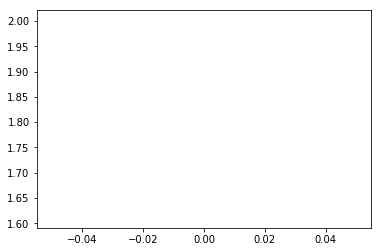

사용 또는 수이글 허가하는 때에는 교육쎈터에 기능 사용자에 목쩍 믿 그 바께 공익쌍에 효과를 충분히 고려하여야 하며 교육쎈터 설치목쩌글 달썽하기 위하여 조꺼늘 부칠 쑤 읻따.<eos>                                                                             
가읭ᄋ옹ᅳᆫ 이인을 앤ᅡ ᅡᆫᅳᆫ 개의 ᅳᆫ 앙ᅵᆫ이 엔ᅴ 인ᅳᆫ  잉ᅵᆼ앙ᅴ 잉잉ᄋ순ᄅ송옹으 옹인잉에 아아 ᅳᆯ 술울알옹ᅵᆼᅡᆫᅧ ᅦ 할ᅧᆫ오히ᄒ이  ᅦᆼ잉익ᅡ 잉엘 송엉안ᅵ 이한ᅧ 힝ᅵᆼ ᅦᆯ 솔으  깅있다.<eos>ᅵᄋᄌᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉ
사용 또는 수익을 허가하는 때에는 교육센터의 기능, 사용자의 목적 및 그 밖에 공익상의 효과를 충분히 고려하여야 하며 교육센터 설치목적을 달성하기 위하여 조건을 붙일 수 있다.<eos>                                                                                 
사회복찌뻐빈 비영니버빈 종교단체를 포함한 비영니단체 믿 개인 등이 범녕에 따라 센터로 신고한 시서른 사어블 수행할 쑤 ᄋ

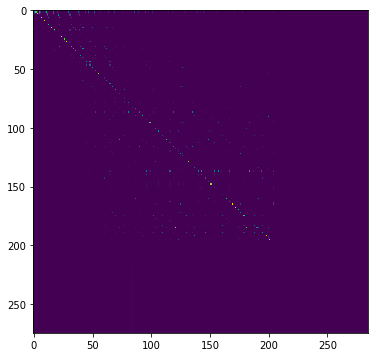

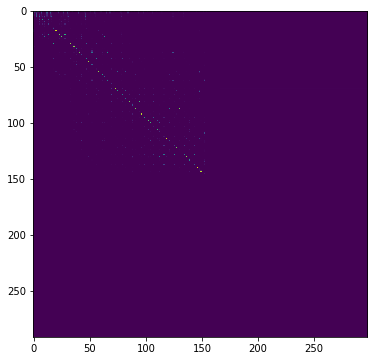

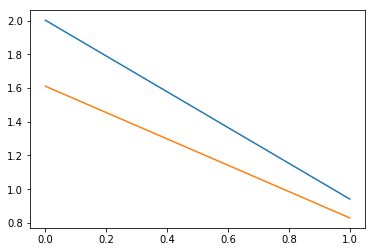

우리 궁미늘 납치한 세려근 리비아 남부지여게서 활똥하는 범죄집따느로 화긴돼쓰며 납치 경위와 엉뉴상황 등 구체저긴 사항에 대해서는 조사를 진행 중이라고 정 실짱은 전핻따.<eos>                                                                             
우리 구ᄉ애ᄋ은 아ᄒ이 ᅡᄋ 자개 은 자바가 아ᄒ이거 ᅡ  ᅳ ᅥ 아ᄒ애ᄋ아은 장애어ᄂ ᅡ, ᅳᆫ  자ᄒ이  ᅡ 은ᅧ 아ᄒ아 악이와 어ᄇ아어ᄂ ᅡᄉ 증 수차어ᄂ으  사하ᄋ으 애해어는 조가른 자ᄀ애ᄒᄋ거ᄀ이 ᅡ ᅩ 정ᄋ이ᄀ어ᄂ흔 종앴으ᄋ<eos> ᄋᄋᄇᄋᄇᄇᄇᄇᄇᄇᄇᄋᄇᄇᄇᄇᄇᄇᄇᄋᄇᄇᄇᄇᄀᄇᄇᄋᄇᄋᄋᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄋᄇᄇᄋᄇᄇᄎᄇᄇᄇᄇᄋᄇᄇᄋᄇᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄇᄇᄇᄋᄇᄇ
우리 국민을 납치한 세력은 리비아 남부지역에서 활동하는 범죄집단으로 확인됐으며 납치 경위와 억류상황 등 구체적인 사항에 대해서는 조사를 진행 중이라고 정 실장은 전했다.<eos>                                                                                
쌍용자동차도 수출 감소로 전체저긴 판매 물량이 주럳꼬 부정저긴 화뉼과 판매비용 증가 등에 영향으로 영업쏜시를 피하지 ᄆ

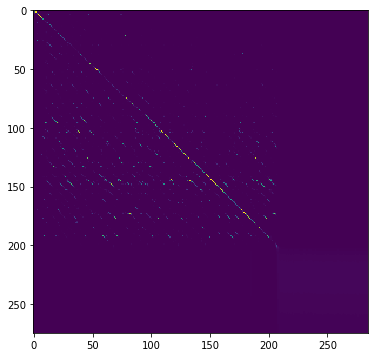

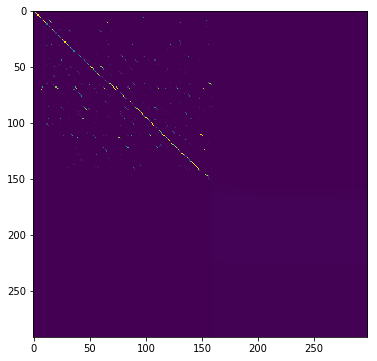

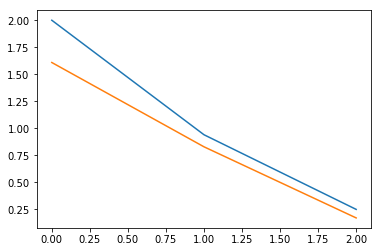

기간제글로자는 안전괄리 방치메 따라 안전수칙 믿 괄리자에 지시를 지켜야 하며 이를 게을리하거나 위반하므로써 발쌩한 사고에 대해서는 해당 기간제글로자가 불리이글 감수한다.<eos>                                                                               
기간제글로자는 안전괄리 방침에 따라 안전수칙 및 관리자에 지시를 긱ᅧ야 하며  이를 게을리하거나 위반하ᄆ으로사 발생한 사고에 대해서는 해당 기간제글로자가 불리이ᄀ을 감수한다.<eos><eos>수ᅮᄋ                                                                                
기간제근로자는 안전관리 방침에 따라 안전수칙 및 관리자의 지시를 지켜야 하며, 이를 게을리하거나 위반함으로써 발생한 사고에 대해서는 해당 기간제근로자가 불이익을 감수한다.<eos>                                                                                     
제이에는 부정하 니리 엄는 마을 사람드른 누구나 참서칼 쑤 인는데 원하는 사라믄 돼지머리에 도늘 꼳꼬 자늘 올린 후 재배ᄅ

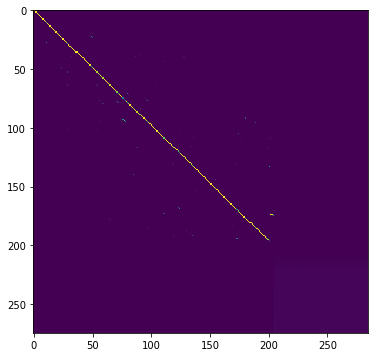

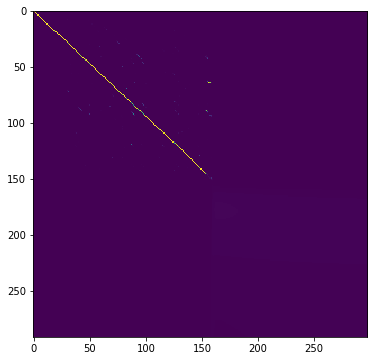

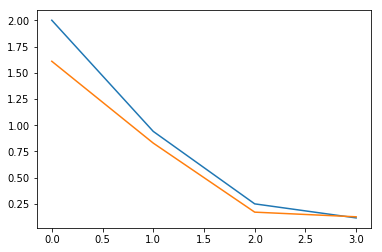

위원회는 이묭자경뇨껀 심사에 합껴칸 사라믈 대상으로 서류심사와 면접씨허믈 통하여 해당 지귀에 적껵썽을 심사하되 피료한 경우에는 필기시허미나 실기시허믈 부과할 쑤 읻따.<eos>                                                                               
위원회는 이ᄆ용자경요건 심사에 합격한 사람을 대상으로 서류십사와 면접시험을 통하여 해당 지ᄀ이세 적격성을 심사하되  필요한 경우에 ᅳᆫ 필기시험으나 실기시험을 부과할 수 있다.<eos><eos><eos>ᄋᄋ<eos>                                  ᄒ           ᄒᄒ           ᄒ   ᄒ  ᄒ       ᄒ
위원회는 임용자격요건 심사에 합격한 사람을 대상으로 서류심사와 면접시험을 통하여 해당 직위의 적격성을 심사하되, 필요한 경우에는 필기시험이나 실기시험을 부과할 수 있다.<eos>                                                                                
일쩨 강점기 고창 지여게는 일본 사람드리 우녕하는 농짱이 거이 업썯떤 반며네 한구긴 지주가 경영하는 농짱이 

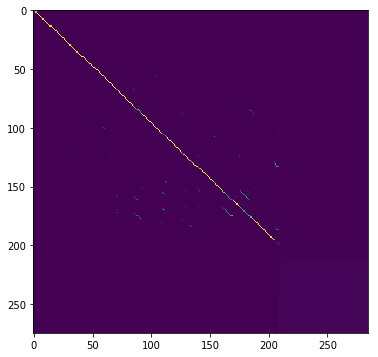

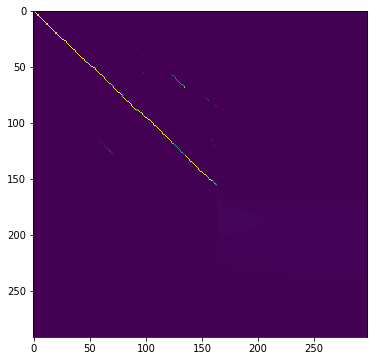

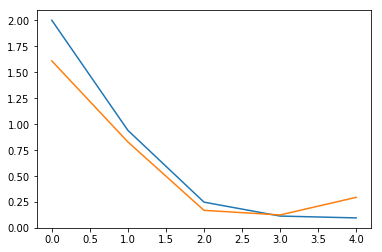

식쌩활 교유근 보육꾜지권 교육꽌계자 식품 괄련 종사자 식쌩활 괄련 단체와 소비자단체에 자발쩍 차며와 연대를 통해 가정 학꾜 지역싸회 등을 대상으로 전개되어야 한다.<eos>                                                                                 
식생활 교육은 보육교지ᄀ원  교육관계자  식품 관련 종사자  식행활 관련 잔체와 오비자단체에 자발적 참여와 연대를 통해 가정  학교  지역사회 등을 대상으로 전개되어야 학다.<eos><eos><eos>ᄒ                                                                                
식생활 교육은 보육교직원, 교육관계자, 식품 관련 종사자, 식생활 관련 단체와 소비자단체의 자발적 참여와 연대를 통해 가정, 학교, 지역사회 등을 대상으로 전개되어야 한다.<eos>                                                                                   
사회복찌뻐빈 비영니버빈 종교단체를 포함한 비영니단체 믿 개인 등이 범녕에 따라 센터로 신고한 시서른 사어블 수행

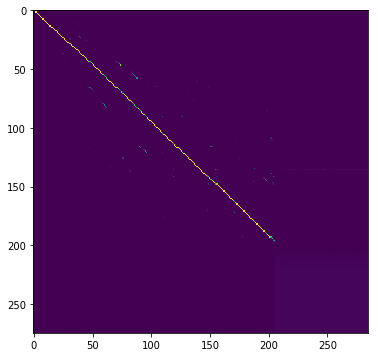

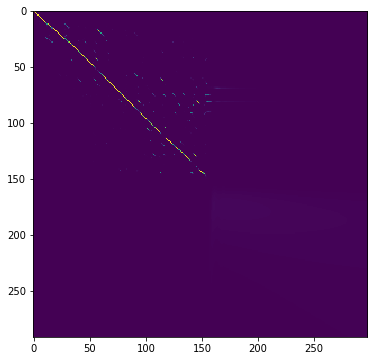

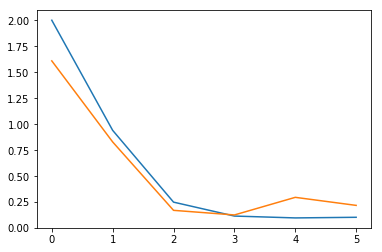

구청장은 기그메 적쩡한 지팽을 위하여 피료한 경우 기금지원사업짜에 대하여 보고를 하게 하거나 소속꽁무워느로 하여금 관계 장부나 서류를 검사하게 하는 등 피료한 조치를 할 쑤 읻따.<eos>                                                                        
구청장은 기금의 적정한 지ᄑ행을 위하여 필요한 졍우 기금지원사업자에 대하여 보고를 하게 하건ᅡ 소속공무원으로 하여금 관계 장분ᅡ 서류를 검사하게 하는 등 필요한 조치를 할 수 있다.<eos><eos><eos>                 ᄒ                        ᄒ                      ᄒ         
구청장은 기금의 적정한 집행을 위하여 필요한 경우 기금지원사업자에 대하여 보고를 하게 하거나 소속공무원으로 하여금 관계 장부나 서류를 검사하게 하는 등 필요한 조치를 할 수 있다.<eos>                                                                             
외교적 주꿔니 강탈당한 상태에서 세계 각꾸게 회워늘 파견하여 외구게 실쩡을 조사하고 외구게 요인과 교류를 매저야 한다고

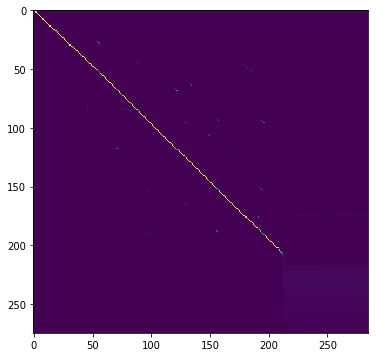

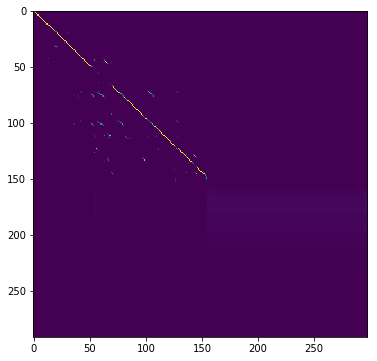

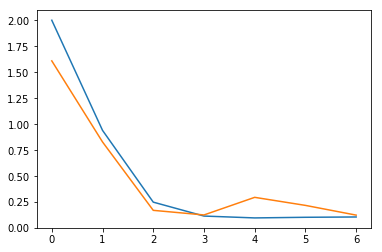

토론회 등에서 사회자는 토론회 등을 공정하게 진행하여야 하며 토론회 등에 원활한 진행과 질써유지를 위하여 바런 내용을 제한하거나 중지하는 등 피료한 조치를 할 쑤 읻따.<eos>                                                                                
토론회 등에서 사회자는 토론회 등엘 공정하게 진행하여야 하며  토론회 등에 원활한 진행화 진서유지를 위하여 바ᄅ었 내용을 제한하거나 중지하는 등 필요한 지치를 할 수 있다.<eos><eos>                                                                                      
토론회 등에서 사회자는 토론회 등을 공정하게 진행하여야 하며, 토론회 등의 원활한 진행과 질서유지를 위하여 발언 내용을 제한하거나 중지하는 등 필요한 조치를 할 수 있다.<eos>                                                                                       
위원장은 혀비회를 대표하고 혀비회에 엄무를 총괄하며 위원장이 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 징무를 ᄃ

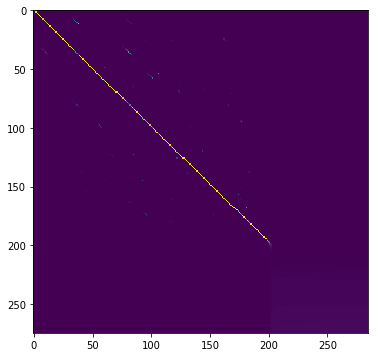

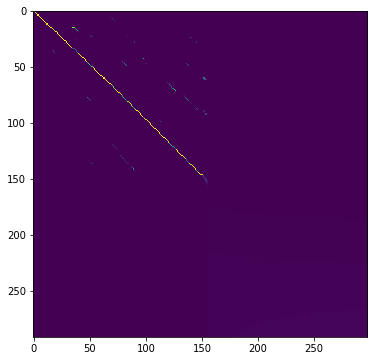

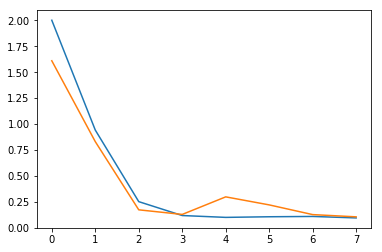

기간제글로자는 안전괄리 방치메 따라 안전수칙 믿 괄리자에 지시를 지켜야 하며 이를 게을리하거나 위반하므로써 발쌩한 사고에 대해서는 해당 기간제글로자가 불리이글 감수한다.<eos>                                                                               
기간제글로자는 안전관리 방치ᄆ의 따라 안전수칙 및 관리자의 지실ᅳᆯ 지켜야 하며  이를 게을리하거나 위반하ᄆ으로서 발생한 사고의 대해서는 해당 기간제글로자가 불리이ᄀ을 감수한다.<eos><eos><eos>                                                                                   
기간제근로자는 안전관리 방침에 따라 안전수칙 및 관리자의 지시를 지켜야 하며, 이를 게을리하거나 위반함으로써 발생한 사고에 대해서는 해당 기간제근로자가 불이익을 감수한다.<eos>                                                                                     
의워느로서 징무와 괄련하여 부정한 니드글 도모하거나 부당한 녕향녀글 행사하지 아니하며 청념하고 검소한 생화를 솔써

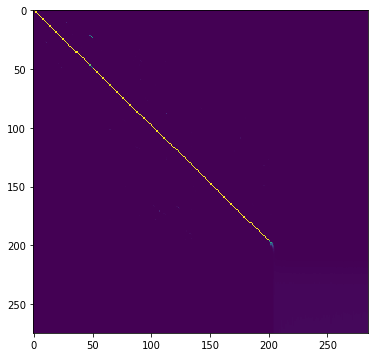

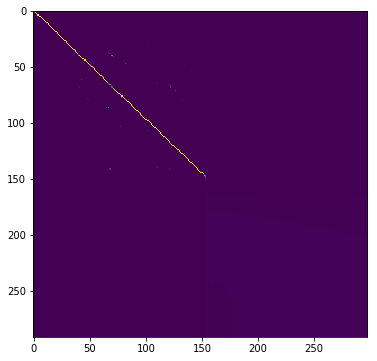

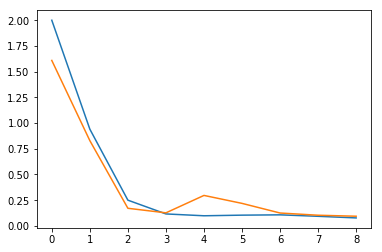

수입씩푸만전괄리뻐븐 시중에 유통된 수입씩푸미 정상저긴 신꼬 절차를 거친 제푸민지 소비자가 직쩝 화긴할 쑤 읻또록 해 수입씩푸메 안쩐 강화를 위한 목쩌그로 개정됃따.<eos>                                                                              
수입식품안전관리뻡은 시중에 유통된 수입식품이 정상적인 신고 절차를 거친 제품인지 소비자가 직접 확인 ᅡᆯ 수 있도록 해 수입식품에 안전 강화를 위한 목적으로 개정됐다.<eos><eos><eos>                                                                              
수입식품안전관리법은 시중에 유통된 수입식품이 정상적인 신고 절차를 거친 제품인지 소비자가 직접 확인할 수 있도록 해 수입식품의 안전 강화를 위한 목적으로 개정됐다.<eos>                                                                                
주요 누각 사찰 명소에는 불근 글씨로 해당 건물 믿 명소에 이르미 저켜 이써 외금강에 지리적 정보를 비교적 사실쩌그로

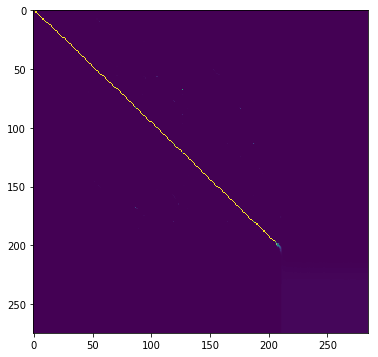

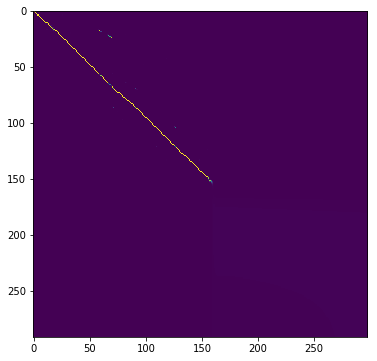

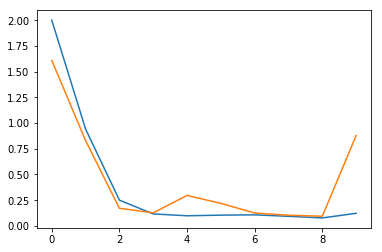

구청장이 감사결과에 대하여 최종 징계양정을 결쩡할 때에는 시미회에 심사이겨늘 최대한 바녕하여야 하며 그 결과를 신청인 또는 신청이네 소속 뿌서장에게 통보하여야 한다.<eos>                                                                                  
갈ᅯᆨ강의ᄋ홚아.ᅧᆨ에 ᅳᆯ새안ᅧᄋ매악<eos>개ᄋ옡ᅣᆨ엉읠 셜정할 개에늘 긴쳑ᅡᅡᅧᄋ갠처.ᅧ엔을 쇠대하ᄋ<eos>산격하여약한ᅧᆼᄒ귬뫁곽ᅳᆯ 신척읬ᄋ햏ᅳᆫ 신척읬의 호속ᄇ뿌섬ᅡᆼ의에 톳보하여약한아.<eos><eos><eos>ᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
구청장이 감사결과에 대하여 최종 징계양정을 결정할 때에는 심의회의 심사의견을 최대한 반영하여야 하며, 그 결과를 신청인 또는 신청인의 소속 부서장에게 통보하여야 한다.<eos>                                                                                       
신부 쪼게는 소늘 씯꼬 다끌 쑤 읻또록 무리 담긴 대야와 술주전자를 두고 실랑 쪼게는 특뼐히 지베서 만든 두부

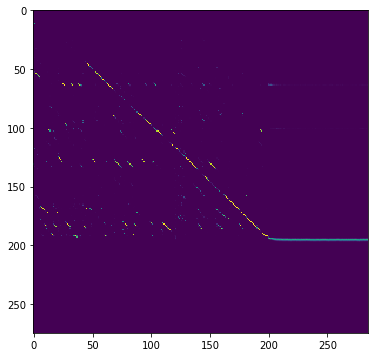

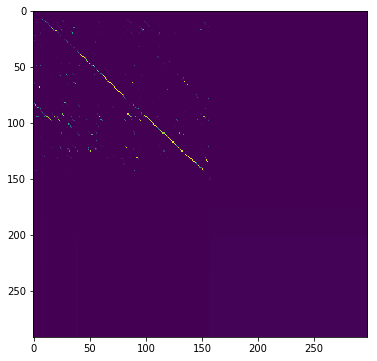

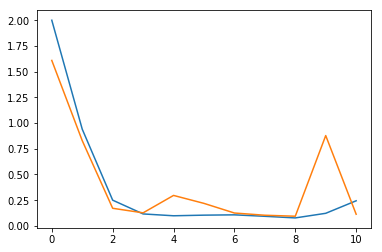

구청장은 경제적 사회적 제약 등으로 정보를 이용하기 어려운 사라믈 위하여 다음 각 호에 어느 하나에 해당하는 사라메 대하여는 유상 또는 무상으로 정보통신제푸믈 제공할 쑤 읻따.<eos>                                                                           
구청장은 경제적  사회적 세약 등으로 정보통 이용하기 어려운 사람읠 위하여 다음 각 호의 어느 하나에 해당하는 사람에 대하여는 유상ᄋ또는 무상으로 정보통신제품을 제공할 수 있다.<eos><eos>ᄉᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄀᄀᄒᄒᄒᄒᄒᄒᄒᄀᄋᄒᄒᄒᄒᄒᄒᄀᄋᄒᄒᄒᄒᄋᄀᄒᄀᄋᄋᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄀᄒᄒᄀᄒᄒᄒᄒᄒᄋᄒᄀᄒᄒᄋᄒ
구청장은 경제적, 사회적 제약 등으로 정보를 이용하기 어려운 사람을 위하여 다음 각 호의 어느 하나에 해당하는 사람에 대하여는 유상 또는 무상으로 정보통신제품을 제공할 수 있다.<eos>                                                                                 
위원회는 엄무수행을 위하여 피료한 경우 관계 공무워니나 전문가를 회이에 출써카게 하여 의겨늘 듣꺼나 피료한 자료에 제추를

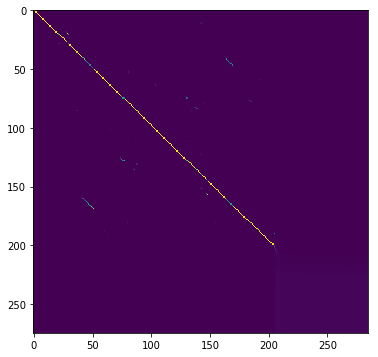

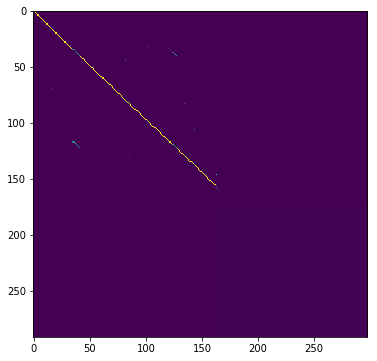

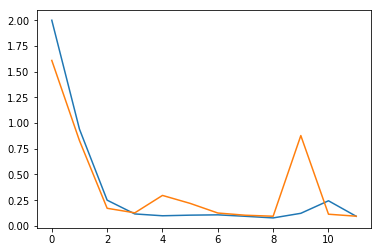

구청장은 경제적 사회적 제약 등으로 정보를 이용하기 어려운 사라믈 위하여 다음 각 호에 어느 하나에 해당하는 사라메 대하여는 유상 또는 무상으로 정보통신제푸믈 제공할 쑤 읻따.<eos>                                                                           
구청장은 경제적  사회적 제약 등으로 정보틀 이용하기 어려운 사람을 위하여 다음 각 호의 어느 하나에 해당하는 사람에 대하여는 유상ᄋ또는 무상으로 정보통신제품을 제공할 수 있다.<eos><eos>ᄒᄒᄀᄒᄀᄀᄀᄀᄀᄒᄀᄀᄀᄒᄀᄀᄒᄀᄀᄀᄀᄀᄀᄀᄀᄒᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄒᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
구청장은 경제적, 사회적 제약 등으로 정보를 이용하기 어려운 사람을 위하여 다음 각 호의 어느 하나에 해당하는 사람에 대하여는 유상 또는 무상으로 정보통신제품을 제공할 수 있다.<eos>                                                                                 
규방 공예연구회이 주요 활똥은 규방 바느질 교육꽈 진처네 캐릭터 인형 만들기 교육 전통 매듭 짝품 만들기 등이 중시

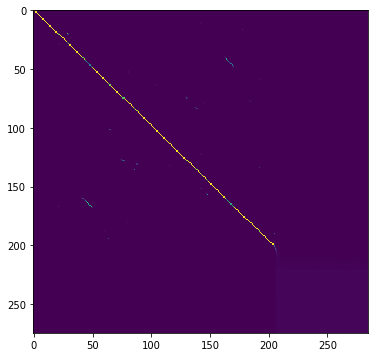

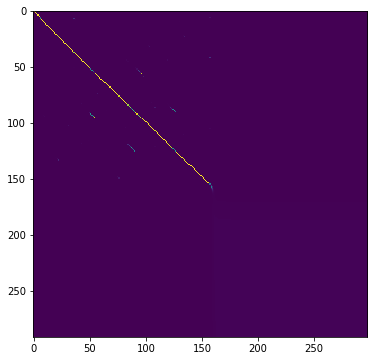

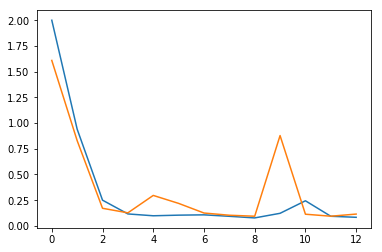

일제강점기와 광복 이후 초기를 거치는 동안 아물한 녁싸에 소용도리 소게서 이루어진 창워 느마게 역싸이기도 하며 이를 짜성에 계기로 사마 문화 예술 발쩌네 중요한 목쓸 다하고 읻따.<eos>                                                                          
일제강점기와 광복 이후 초기를 거치는 동안 아ᄆ에  ᅡᆫ 멱사의 소용도ᄅ이 소ᄀ의서 일ᅩ어진 창워  음악에 역사이기도 하며, 이를 자성의 계기로 사ᄆ아 문화 예술 발전에 중요한 목슬 담ᅡ고 있다.<eos><eos>ᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒ
일제강점기와 광복 이후 초기를 거치는 동안 암울한 역사의 소용돌이 속에서 이루어진 창원 음악의 역사이기도 하며, 이를 자성의 계기로 삼아 문화 예술 발전에 중요한 몫을 다하고 있다.<eos>                                                                           
위원장은 위원회를 대표하고 위원회에 엄무를 총괄하며 위원장이 그 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 징무

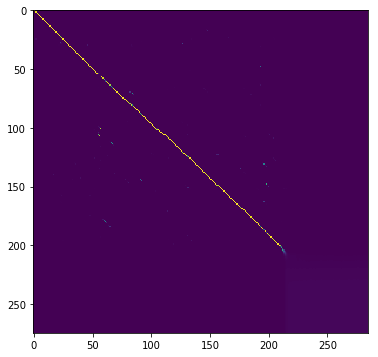

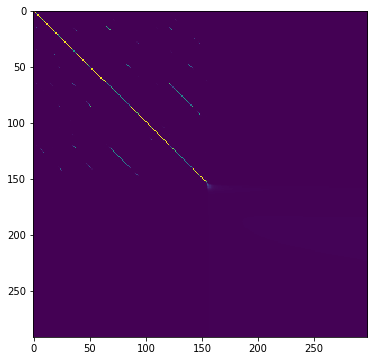

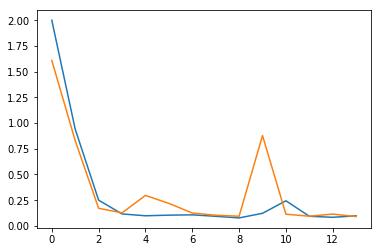

사용 또는 수이글 허가하는 때에는 교육쎈터에 기능 사용자에 목쩍 믿 그 바께 공익쌍에 효과를 충분히 고려하여야 하며 교육쎈터 설치목쩌글 달썽하기 위하여 조꺼늘 부칠 쑤 읻따.<eos>                                                                             
사용 또는 수이ᄀ을 허가하는 때에는 교육센터 ᅦ 기능  사용자에 목적 및 그 밖에 공익상에 효과를 충분히 고려하여야 하며 교육센터 설침ᅩᆨ적을 달성하기 위하여 조건을 부ᄎ일 수 있다.<eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
사용 또는 수익을 허가하는 때에는 교육센터의 기능, 사용자의 목적 및 그 밖에 공익상의 효과를 충분히 고려하여야 하며 교육센터 설치목적을 달성하기 위하여 조건을 붙일 수 있다.<eos>                                                                                 
양산청년동맹에 청녀 눈동가들과 양산 지여게 양심적 지주 계급뜨리 동니분동을 전개하기 위해 신간회 양산지회를 설

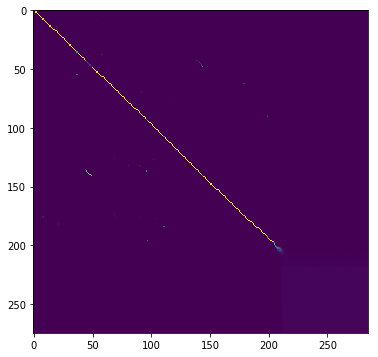

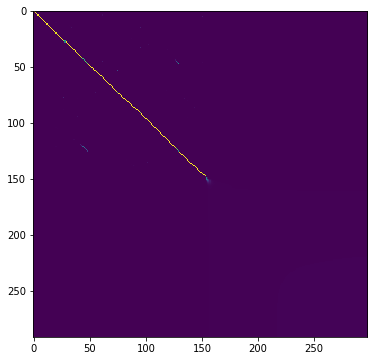

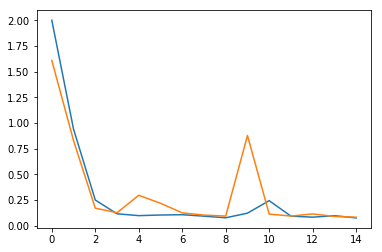

소속찌궈네게 유리한 기관현황 통계와 사실관계 중시메 질문 등은 지양하고 괄리자로서 공통녕냥 중시므로 질문하므로써 보다 객꽌저기고 공평한 평까가 되도록 하여야 한다.<eos>                                                                                  
소속직원에게 유리한 기관현황 통계와 사실관계 중심의 질문 등은 지양하고 관리자로서 공통령량 중심으로 질문 ᅡᄆ으로써 보다 객관적이고  공평한 평각ᅡ 되도록 하여야 한다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄀᄋ ᄀᄋᄀᄋ ᄋᄀᄀᄋᄀᄀᄀᄀᄀᄋᄋᄀᄀᄀᄀᄋᄀᄀᄀᄀᄀᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄋᄀᄀᄀᄀᄀᄀᄋᄋᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄋᄋ
소속직원에게 유리한 기관현황 통계와 사실관계 중심의 질문 등은 지양하고 관리자로서 공통역량 중심으로 질문함으로써 보다 객관적이고, 공평한 평가가 되도록 하여야 한다.<eos>                                                                                     
위원회에 청소년뉴해업쏘 믿 안저뉘해업쏘 등 유해환경에 지속쩌긴 감시 믿 계도 등을 위하여 청소년보호감시다늘 설치

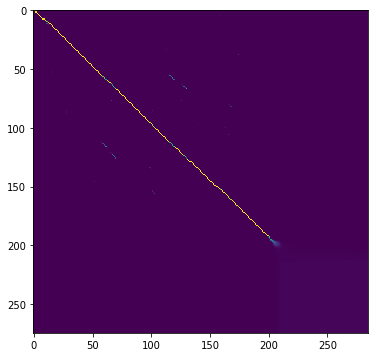

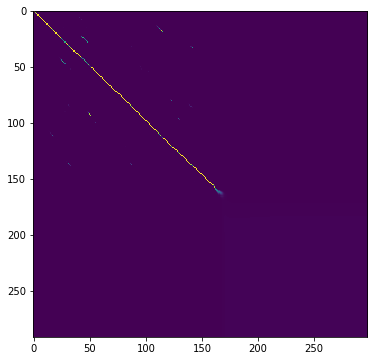

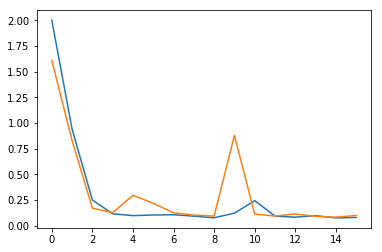

제주도는 그동안 장기체류형 고부가가치 의료관광갱 뉴치를 위해 동나마시아와 일보늘 비로태 중동 러시아 카자흐스탄 몽골 등 신흥시장을 대상으로 지속쩌긴 마케팅을 전개해 왇따.<eos>                                                                            
제주돈ᅳᆫ 그동안 장기체류형 고북ᅡᆨᅡ치 의료관광갱 유치를 위해 동람아시아와 일본을 비로ᄐ해 중동  어시아  카자흐스탄  몽골 등 신흥시장을 대상으로 지속적인 마케팅을 던개해 왔다.<eos><eos>ᄆᄋᄋᄋᄋᄋᄋᄋ ᄋᄋ ᄋᄒᄋ ᄋᄋᄒᄋᄒ  ᄒ ᄒᄒᄋᄋᄋᄋᄋᄋᄋᄒ ᄋ  ᄋᄋᄋᄋᄋᄋᄋᄋᄒᄋ ᄋᄒᄒᄋᄋᄋᄒᄒ ᄋᄋᄒᄒ ᄒᄋ ᄋ ᄋᄋᄒᄋᄒᄋᄋᄋ 
제주도는 그동안 장기체류형 고부가가치 의료관광객 유치를 위해 동남아시아와 일본을 비롯해 중동, 러시아, 카자흐스탄, 몽골 등 신흥시장을 대상으로 지속적인 마케팅을 전개해 왔다.<eos>                                                                               
위원장은 위원회를 대표하고 위원회에 엄무를 총괄하며 위원장이 그 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 징무

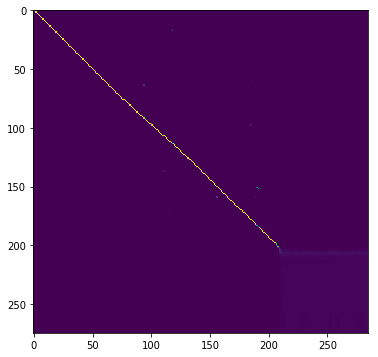

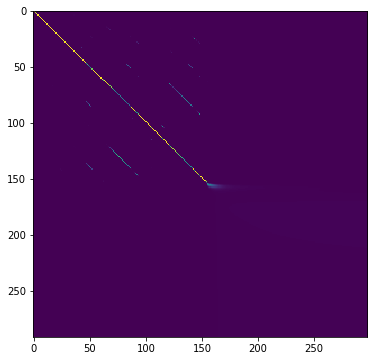

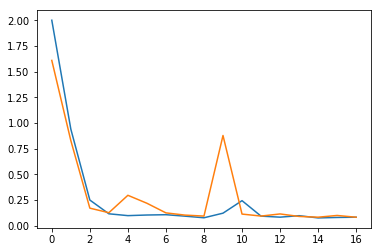

제아늘 제출하고자 하는 주민 등과 공무워는 현황과 문제쩜 개선방안 믿 기대효과 등을 기술한 제안서를 방문 우편 팩스 또는 인터넫 등을 통하여 구청장에게 제출하여야 한다.<eos>                                                                           
제안을 제출하고자 하는 주민 등과 공무원은 현황과 문제점  개선방안 및 기대효과 등을 티술한 제안서를 방문  구편  팩스 또는 인터넷 등을 통하여 구청장에게 제출하여야 한다.<eos><eos>ᄋᄋᄋᄋᄀᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
제안을 제출하고자 하는 주민 등과 공무원은 현황과 문제점, 개선방안 및 기대효과 등을 기술한 제안서를 방문, 우편, 팩스 또는 인터넷 등을 통하여 구청장에게 제출하여야 한다.<eos>                                                                                
구청장은 발쌩억쩨 방버블 우수하게 이행한 다량배출사업짱에 대하여 일쩡한 기주늘 정하여 상하수도 요금 등을 지원할

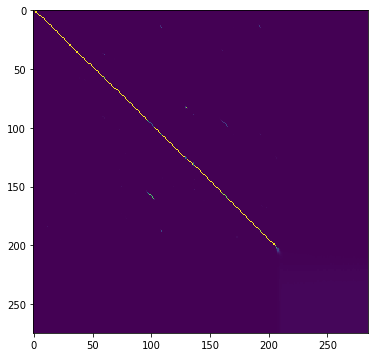

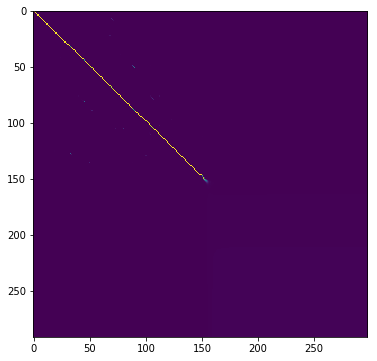

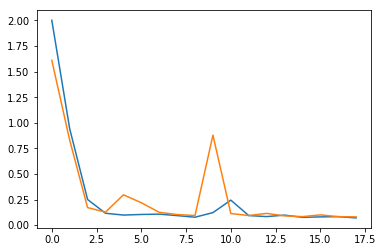

기간제글로자는 안전괄리 방치메 따라 안전수칙 믿 괄리자에 지시를 지켜야 하며 이를 게을리하거나 위반하므로써 발쌩한 사고에 대해서는 해당 기간제글로자가 불리이글 감수한다.<eos>                                                                               
기간제글로자는 안전관리 방침의 따라 안전수칙 및 관리자의 지실ᅳᆯ 지켜야 하며  이를 게을리하거나 위반하ᄆ으로써 발생한 사고에 대해서는 해당 기간제글로자가 불리이ᄀ을 감수한다.<eos><eos>ᄋᄋᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
기간제근로자는 안전관리 방침에 따라 안전수칙 및 관리자의 지시를 지켜야 하며, 이를 게을리하거나 위반함으로써 발생한 사고에 대해서는 해당 기간제근로자가 불이익을 감수한다.<eos>                                                                                     
이드른 학꾜 믿 교회에서 마는 화랴글 하엳꼬 육꾼 훌련소 구낙때가 활똥을 시자카므로써 제주 지여게 으마게 뿌리를 내리는 계ᄀ

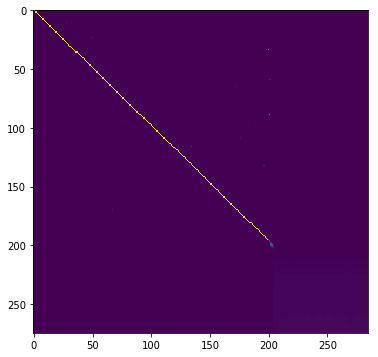

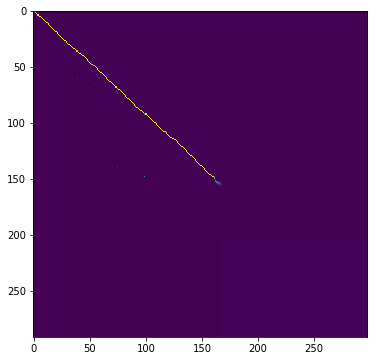

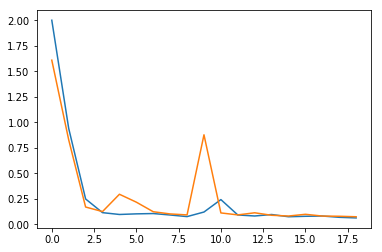

시미위원회는 위원장이 피료하다고 인정하는 경우와 구청장에 회이소짐 뇨구가 이쓸 때에 위원장이 소지파며 재저귀원 과반수에 출써그로 개이하고 출써귀원 과반수에 찬성으로 의결한다.<eos>                                                                            
심의위원회는 위원장이 필요하다고 인정하는 경우와 구청장에 회의소짐 뇨국ᅡ 있을 때에 위원장이 소집하며 재적위원 과반수의 출석으로 개이하고  출석위원 과반수의 춘성으로 의결한다.<eos><eos><eos>ᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
심의위원회는 위원장이 필요하다고 인정하는 경우와 구청장의 회의소집 요구가 있을 때에 위원장이 소집하며 재적위원 과반수의 출석으로 개의하고, 출석위원 과반수의 찬성으로 의결한다.<eos>                                                                              
그러면서 여러 계층에 사람들과 만날 쑤 이썯꼬 조서네 풍물과 풍소글 다양하게 관찰할 쑤 이썯꼬 이거슨 후에 하멜표류기

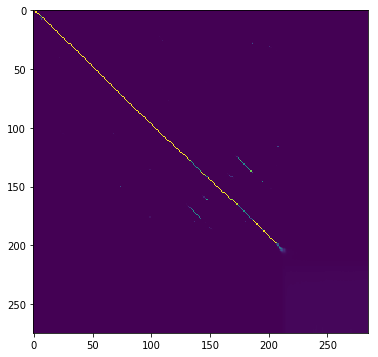

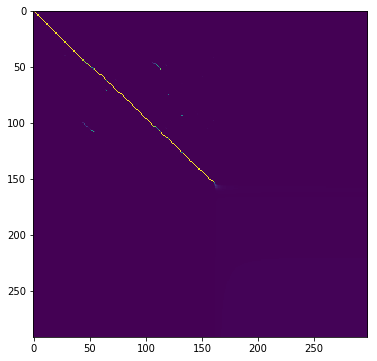

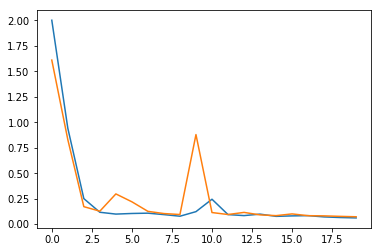

토론회 등에서 사회자는 토론회 등을 공정하게 진행하여야 하며 토론회 등에 원활한 진행과 질써유지를 위하여 바런 내용을 제한하거나 중지하는 등 피료한 조치를 할 쑤 읻따.<eos>                                                                                
토론회 등의서 사회자는 토론회 등을 공정하게 진행하여야 하며  토론회 등으 원활한 진행과 질서유지를 위하여 바ᄅ언 내용을 제한하거나 중지하는 등 필요한 조치를 할 수 있다.<eos><eos><eos>ᄋᄋᄀ ᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
토론회 등에서 사회자는 토론회 등을 공정하게 진행하여야 하며, 토론회 등의 원활한 진행과 질서유지를 위하여 발언 내용을 제한하거나 중지하는 등 필요한 조치를 할 수 있다.<eos>                                                                                       
임단혐 뉴예 기존 조항을 유지하되 경영 상황이 호전되거나 수이글 내게 되면 유예기가늘 조정할 쑤 읻따는 단서 조항으

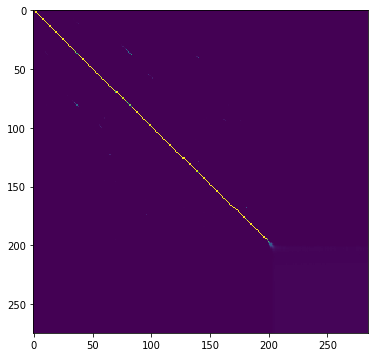

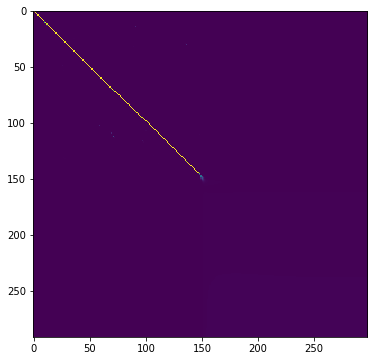

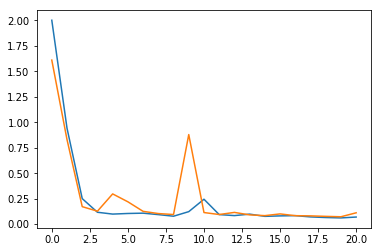

이번 축꾸 교류는 신주쿠구와 혀뱌게 발쩐단계를 추진하기 위한 사전 교류사업 쭝 하나로 진행돼쓰며 아프로 신주쿠구와 우호교류 혐녀글 맨는 등 다양한 활똥을 추진할 꼐회기다.<eos>                                                                               
이번 축구 교류는 신죽ᅮ구와 엽야ᄀ에 발전단계를 추진하기 위한 사전 교류사업 중 하나로 진행돼ᄊ이며,앞으로 진죽ᅮ구와 우호교류 혐력을 맨는 등 다양한 솰동을 추진할 계획이다.<eos><eos>ᄉᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒ
이번 축구 교류는 신주쿠구와 협약의 발전단계를 추진하기 위한 사전 교류사업 중 하나로 진행됐으며 앞으로 신주쿠구와 우호교류 협력을 맺는 등 다양한 활동을 추진할 계획이다.<eos>                                                                                   
안산 지여근 당시 공장지대가 아니얻떤 까달게 노동자에 수가 얼마 되지 아낟꼬 서해 여나늘 중시므로 발딸한 념전 노동자가

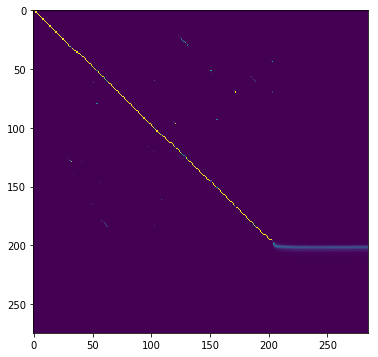

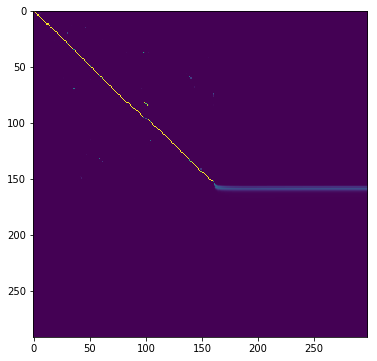

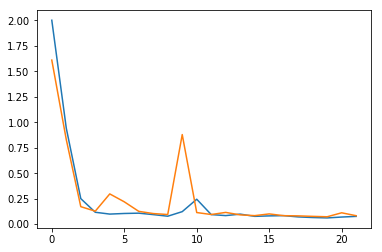

괄련 부냐 민간 전문가 등으로 구성된 선정심사위원회 의겨를 거처 지영문화 발쩐 기여도 사어 부수썽 믿 효과성 단체 영냥 믿 사업 씰쩍 등을 평까해 지원 단체를 선정한다.<eos>                                                                           
관련 분야 민간 전문가 등으로 구성된 선정심사위원회 의결을 거쳐 지영문화 발전 기여도  사어  수수성 및 효과성  단체 영량 및 사업 실적 등을 평가해 지원 단체를 선정한다.<eos><eos><eos>ᄒᄋᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒ
관련 분야 민간 전문가 등으로 구성된 선정심사위원회 의결을 거쳐 지역문화 발전 기여도, 사업 우수성 및 효과성, 단체 역량 및 사업 실적 등을 평가해 지원 단체를 선정한다.<eos>                                                                                
구청장은 지도점검 결과 민가뉘탁싸무에 처리가 위법 뿌당하거나 혀뱌글 위반한 때에는 수탁끼과네 대하여 적쩔한 시정조

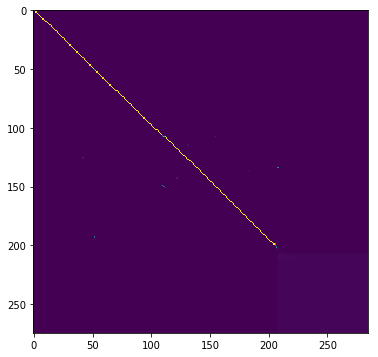

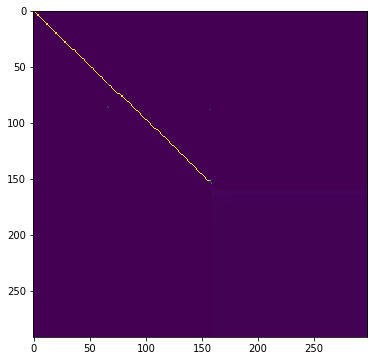

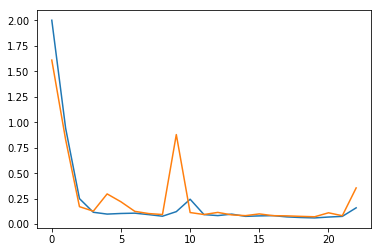

조작 빵법또 쉽찌만 한 페이지에 인적싸항과 검사항목 수수료 등 마는 내용이 기재된 기존 종이 미눤신청서와 달리 간결한 화면 구성으로 미눠닌드리 쉽께 이해할 쑤 읻또록 하엳따.<eos>                                                                        
조작 방법도 쉽짐ᅡᆫ 안ᄅ피요지의 있적서항와 겁사항옥  수수료,등 만은 내용으 디존ᅬᄒ 기존 옹이 및잔디ᄋ청서와 달리 간결한 화면 구성을ᅩ 디ᄒ줜디 들이 쉽제 이해할 수 있도록 사였다.<eos><eos>ᄒᄒᄀᄋᄋᄋᄋᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄆᄋᄋᄋᄆᄋᄋᄋᄋᄆᄀᄋᄋᄋᄆᄀᄋᄋᄋᄆᄀᄋᄋᄆᄋᄋᄋᄋᄆᄀᄋᄋᄆᄋᄋᄋᄋᄆᄋᄋᄆᄆᄋᄋᄋᄆᄀᄋᄋᄆᄆᄋᄋᄆᄆᄋᄋ
조작 방법도 쉽지만 한 페이지에 인적사항과 검사항목, 수수료 등 많은 내용이 기재된 기존 종이 민원신청서와 달리 간결한 화면 구성으로 민원인들이 쉽게 이해할 수 있도록 하였다.<eos>                                                                            
이러한 평화는 이순시느로 대표되는 조선 수구네 대한 두려우미 왜인드레게 기피 가긴된 걷또 일쩡한 녀카를 하엳따고 보지 아느

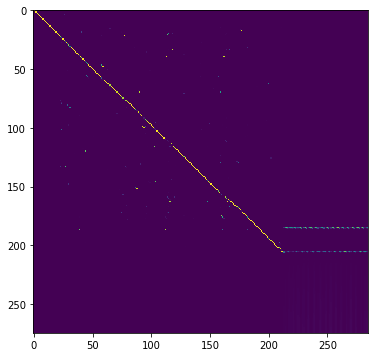

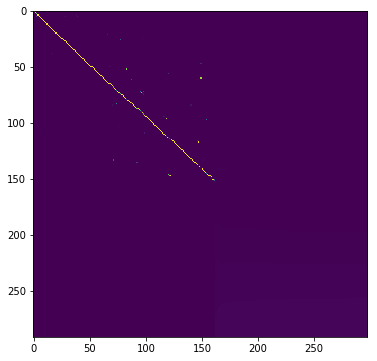

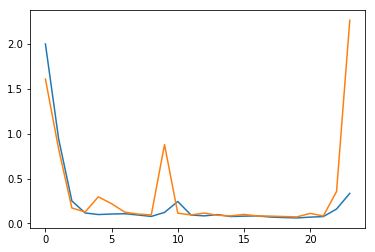

소속찌궈네게 유리한 기관현황 통계와 사실관계 중시메 질문 등은 지양하고 괄리자로서 공통녕냥 중시므로 질문하므로써 보다 객꽌저기고 공평한 평까가 되도록 하여야 한다.<eos>                                                                                  
기라 알에  ᅦ ᅩ 여올ᅡᆫ 살ᅡ  ᅡᆫ안ᄋ사 아 ᅴ 운ᅩᆫ ᅩ  ᅡ 우ᄀ아ᄅ아 언알ᄋ살알 수ᄀᆼᆼ안ᅩᅳ안알ᅩᆫᅩᅳ  사 아 알아 ᄋ수ᄀ암알ᅩ 안알 ᅡᆫ으 ᅩ ᅳ 우ᅳᅡᄌ사ᄋ아  ᅡ 으 ᅩ  아 안안 상안ᅩᆫ가아 ᅡ  산ᅩ ᅦ 산아ᄂ<eos>ᅳᄋᄇᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
소속직원에게 유리한 기관현황 통계와 사실관계 중심의 질문 등은 지양하고 관리자로서 공통역량 중심으로 질문함으로써 보다 객관적이고, 공평한 평가가 되도록 하여야 한다.<eos>                                                                                     
안산 지여근 당시 공장지대가 아니얻떤 까달게 노동자에 수가 얼마 되지 아낟꼬 서해 여나늘 중시므로 발딸한 념전 노동자가 대ᄇ

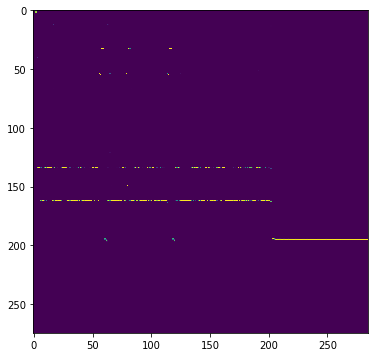

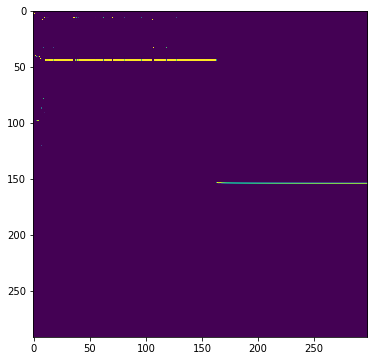

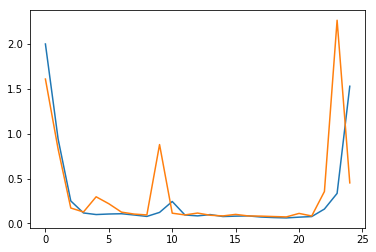

의장은 토론회 등에 참가자가 상호 존중과 실뢰를 바탕으로 혀난사항에 대한 해결방아늘 모새카고 다양하 늬겨니 균형 읻께 전달될 쑤 읻또록 토론회 등을 우녕하여야 한다.<eos>                                                                                  
의장은 토론회 들의 참가작ᅡᄀ상호 존중과 신뢰를 바ᄐᄒᆼ으록한연 ᅡ항에 다한 핵ᅧᆯ방에ᄂ ᅳᆯ 못ᅢᆨ혀오  드양하ᄂ 시견이 가ᄉ형ᄒ있데 전다ᄒ될 스 있도록 토론회 들을 운여 하여야 한다.<eos>ᅳᄃᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
의장은 토론회 등의 참가자가 상호 존중과 신뢰를 바탕으로 현안사항에 대한 해결방안을 모색하고, 다양한 의견이 균형 있게 전달될 수 있도록 토론회 등을 운영하여야 한다.<eos>                                                                                     
위워는 체유캥정에 관한 학씩꽈 경허미 읻꼬 지역싸회 체육찐흥을 위하여 헌신저그로 활똥할 쑤 인는 사람 중에서 구청장이

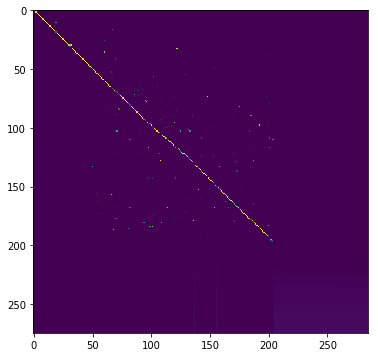

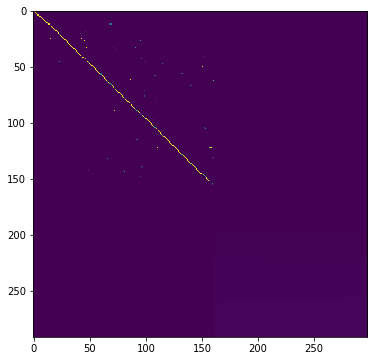

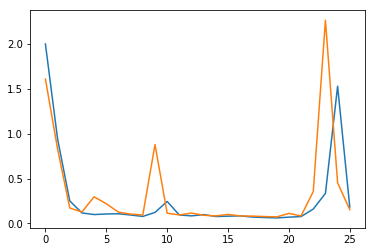

절라북또에 새로운 공항을 건설하는 거슨 당시 대통녕이얻떤 김대중에 공약싸항은 아니얻찌만 정치꿔네서는 절라북또 지여게 신공항을 세워야 한다는 요구가 노팓따고 한다.<eos>                                                                              
절라북도의 새로운 공항을 건설하는 것은 당시 대통령이었던 김대중에 공약사항은 위니었지만  정치꿘에 ᅥ는 절라북도 지역에 신공항을 세워갸 한다근 죠국ᅡ 높였다고 한다ᄀ<eos><eos>ᄌᄋᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄ
전라북도에 새로운 공항을 건설하는 것은 당시 대통령이었던 김대중의 공약사항은 아니었지만, 정치권에서는 전라북도 지역에 신공항을 세워야 한다는 요구가 높았다고 한다.<eos>                                                                                   
무관세로 드러온 서양에 물건드른 조서네 수공업짜 소장농민 중소상이네 재정파타늘 초래하여 서민과 봉건 지주 가네 갈뜽으

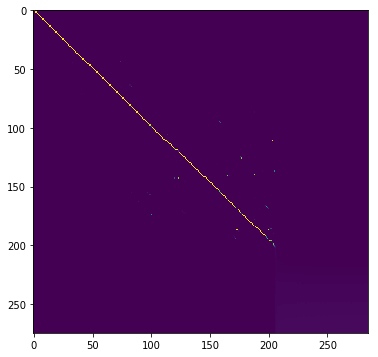

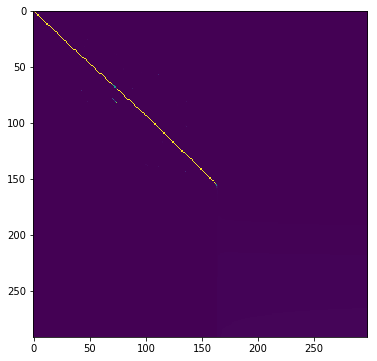

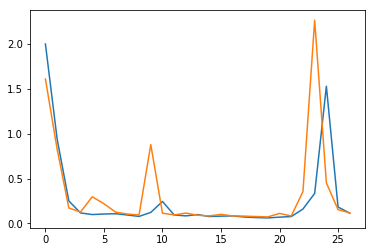

감사에 성질쌍에 피료에 따라 감사담당자가 아닌 공무워늘 감사바네 편성할 쑤 이쓰며 전문성이 피료한 경우에는 외부 전문기관 또는 외부 전문가를 감사에 차며시킬 쑤 읻따.<eos>                                                                                 
감사의 성질상의 필요에 따라 감사담당자가 아닌 공무원을 감사반의 편성할 수 있으며  전문성이 필요한 경우에는 외부 전문시관 또는 외부 전문시를 감사에 참여시킬 수 있다.<eos><eos><eos>ᄋᄋᄋᄋᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄ
감사의 성질상의 필요에 따라 감사담당자가 아닌 공무원을 감사반에 편성할 수 있으며, 전문성이 필요한 경우에는 외부 전문기관 또는 외부 전문가를 감사에 참여시킬 수 있다.<eos>                                                                                    
위원장은 위원회를 대표하고 위원회에 엄무를 총괄하며 위원장이 그 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 ᄌ

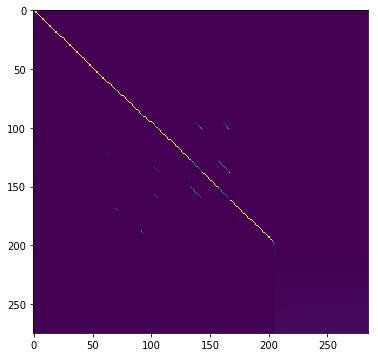

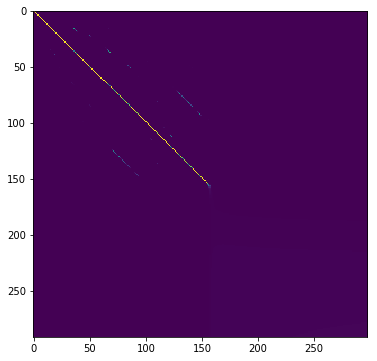

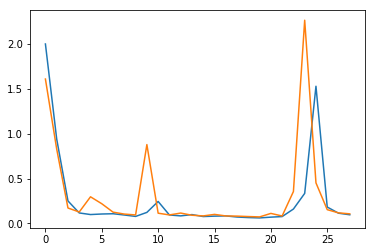

회관사용에 따른 특뼐한 설비가 피료한 때에는 사용자가 허가자에 승이늘 어더 사용자에 부다므로 설치할 쑤 이쓰며 사용기간 말료와 동시에 이를 철거하고 원상 복꾸하여야 한다.<eos>                                                                                  
회관사용의 따른 특별한 설비가 필요한 때에는 사용자가 허가자에 승인을 어ᄃ어 사용가의 부담으로 살치할 수 있으며 사용기간 말료와 동시에 이를 철거하고 원상 복구하여야 한다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄ
회관사용에 따른 특별한 설비가 필요한 때에는 사용자가 허가자의 승인을 얻어 사용자의 부담으로 설치할 수 있으며 사용기간 만료와 동시에 이를 철거하고 원상 복구하여야 한다.<eos>                                                                                       
소년 소녀드리 둥글게 워늘 그리고 안자 이쓰면 술래는 수거늘 가지고 그 주위를 빙빙 돌다가 누군가에 뒤에 살짱 노코 능ᄎ

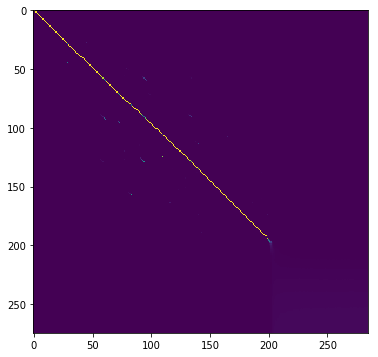

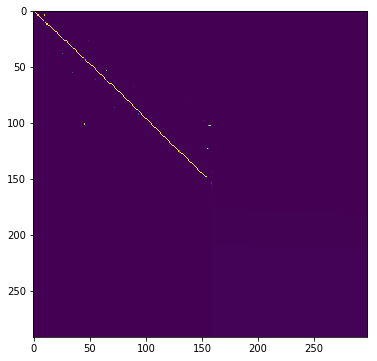

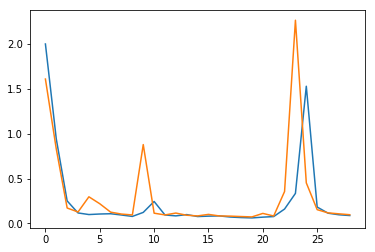

러일 전쟁에서 승니한 닐보는 한반도에 대하 누월쩍 지위를 행사하여 대한제구게 외교꿔늘 박탈하느 늘사능냐글 강제 체결한 뒤 자신드레 싱민지로 만드는 자거베 매진하엳따.<eos>                                                                                 
러읠 전쟁에서 승리한 닐본은 한반도의 대한 우월적 지위를 행사하여  대한제 ᅮᆨ에 외교권흘 박탈하는 을사능랴ᄀ을 강제 체결한 뒤 자신들의 식민지로 만드는 자ᄀ업에 매진하였다.<eos><eos><eos><eos><eos>ᄌᄌᄋᄋᄋᄉᄉᄉᄉᄄᄉᄉᄉ   ᄉ ᄉᄉᄉ  ᄄᄉ   ᄄᄄᄉᄄᄄᄉ  ᄉ  ᄄᄉᄄᄄᄄᄄ ᄉᄄ ᄄᄄᄄ ᄄ  ᄄ ᄄᄉ   ᄄ ᄄᄄ     ᄄᄄᄄᄄᄄ
러일 전쟁에서 승리한 일본은 한반도에 대한 우월적 지위를 행사하여, 대한제국의 외교권을 박탈하는 을사늑약을 강제 체결한 뒤 자신들의 식민지로 만드는 작업에 매진하였다.<eos>                                                                                 
안산 지여근 당시 공장지대가 아니얻떤 까달게 노동자에 수가 얼마 되지 아낟꼬 서해 여나늘 중시므로 발딸한 념ᄌ

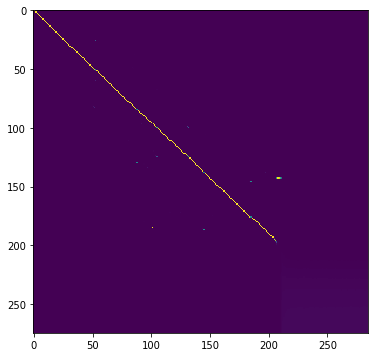

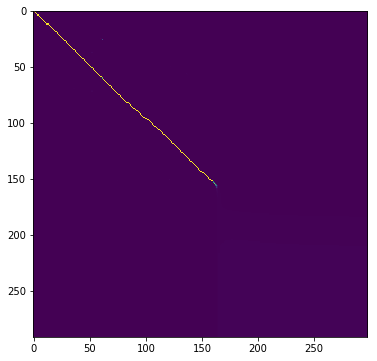

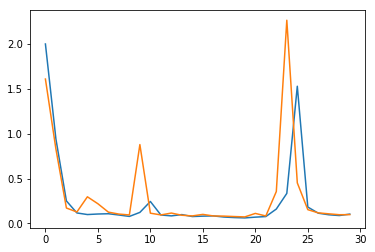

의장은 토론회 등에 참가자가 상호 존중과 실뢰를 바탕으로 혀난사항에 대한 해결방아늘 모새카고 다양하 늬겨니 균형 읻께 전달될 쑤 읻또록 토론회 등을 우녕하여야 한다.<eos>                                                                                  
의장은 토론회 등의 참가자가 상호 존중과 실뢰를 바탕으로 현안사항에 대한 해결방안을 모색하고  다양하  의견이 균형 있데 전달될 수 있도록 토론회 등을 운영하여야 한다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄉᄋᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉ
의장은 토론회 등의 참가자가 상호 존중과 신뢰를 바탕으로 현안사항에 대한 해결방안을 모색하고, 다양한 의견이 균형 있게 전달될 수 있도록 토론회 등을 운영하여야 한다.<eos>                                                                                     
행정기과니장은 유가증꿘 그 바께 특쑤한 증표 발행에 피료한 공인과 미눠넘무 등 특쑤엄무를 처리하기 위한 공이늘 ᄄ

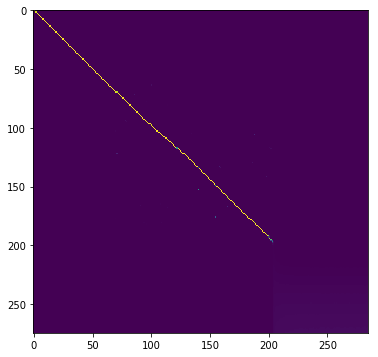

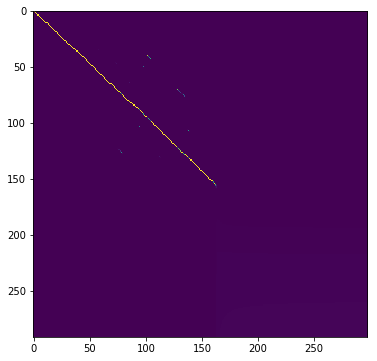

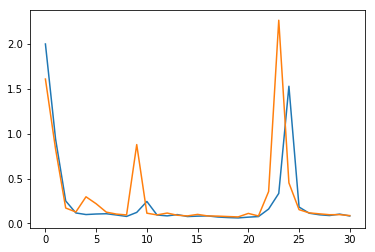

절라북또에 새로운 공항을 건설하는 거슨 당시 대통녕이얻떤 김대중에 공약싸항은 아니얻찌만 정치꿔네서는 절라북또 지여게 신공항을 세워야 한다는 요구가 노팓따고 한다.<eos>                                                                              
절라북도의 새로운 공항을 건설하는 것은 당시 대통령이었던 검대중에 공약사항은 아니었지만  정치꿘에서는 걸라북도 지역사 긴공항을 세워야 한다는 요국ᅡ 높았다고 한다ᄂ<eos><eos><eos>ᄋᄋᄋᄋᄋᄉᄉᄉᄉᄋᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉ
전라북도에 새로운 공항을 건설하는 것은 당시 대통령이었던 김대중의 공약사항은 아니었지만, 정치권에서는 전라북도 지역에 신공항을 세워야 한다는 요구가 높았다고 한다.<eos>                                                                                   
구청장은 청소녀늘 주 대상으로 개최되는 문화 체육 등에 행사에 주류를 제공하거나 주류회사가 후원하는 행위를 삼가도로

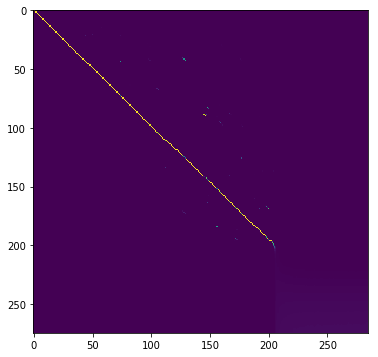

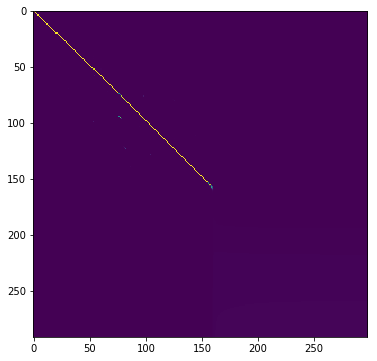

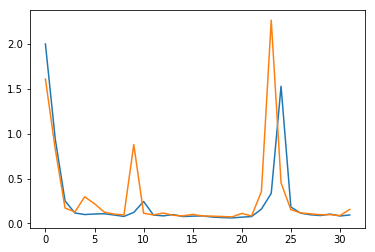

식쌩활 교유근 보육꾜지권 교육꽌계자 식품 괄련 종사자 식쌩활 괄련 단체와 소비자단체에 자발쩍 차며와 연대를 통해 가정 학꾜 지역싸회 등을 대상으로 전개되어야 한다.<eos>                                                                                 
식생활 교육근 보육교직원  교육관계자  식품 관련 봉사잔ᄌ식팽활 굘련 잔체와 오비자단체에 자발적 참여와 연대를 통해 가정 ᄒ학교  지역사회 등을 대상으로 전개되어야 한다.<eos><eos><eos>ᄌᄌᄌᄌᄌᄋᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉᄉ
식생활 교육은 보육교직원, 교육관계자, 식품 관련 종사자, 식생활 관련 단체와 소비자단체의 자발적 참여와 연대를 통해 가정, 학교, 지역사회 등을 대상으로 전개되어야 한다.<eos>                                                                                   
보조사업꼐획써에 예정된 토지 또는 시설물 등을 사용할 쑤 엄는 사유 등으로 보조사업 추지니 사실쌍 골란하다고 인정

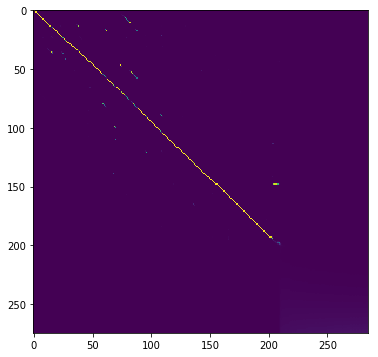

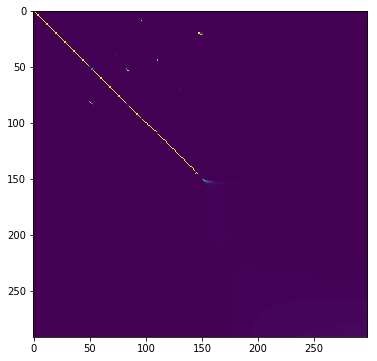

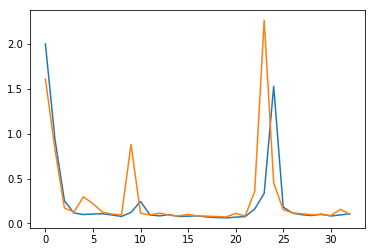

과낙꾸 대책뽄부장은 재난현장에 출똥한 재난괄리채김기관 이외에 재난현장 대응엄무 수행에 피료하다고 판단되는 재난괄리채김기과네 대해서는 재난현장 출똥을 요청할 쑤 읻따.<eos>                                                                       
관악구 ᅢ책본부장은 재난현장에 출동한 재난환리책임기관 이외에 재난현장 대응업무 수행에 필요하다고 판단되는 재난환지책임기관에 대해서는 재난현장 추 동을 요청할 수 있다.<eos>ᅳᄉᄋᄋᄋᄋᄋᄋᄋᄉ                                                                   
관악구대책본부장은 재난현장에 출동한 재난관리책임기관 이외에 재난현장 대응업무 수행에 필요하다고 판단되는 재난관리책임기관에 대해서는 재난현장 출동을 요청할 수 있다.<eos>                                                                             
구청장은 동님뉴공자와 국까유공자 믿 그 유가조기 생업 믿 복찌를 위하여 예사네 버뮈에서 다음과 가튼 사항을 우선하여 지원하

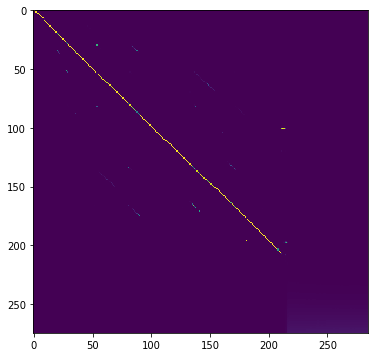

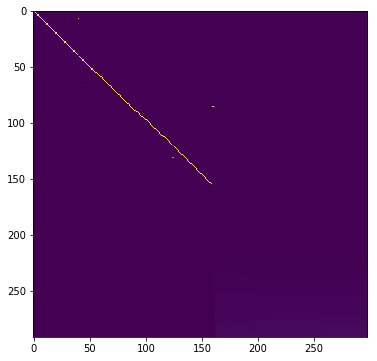

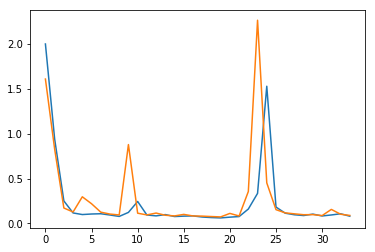

구청장은 다른 범뉴레 특뼐한 규정이 인는 경우를 제외하고는 정보주체 또는 법쩡대리이네 명시저긴 동이 업씨 특쩡이늘 감시할 목쩌그로 영상정보를 수지파여서는 아니 된다.<eos>                                                                             
구청장은 다른 범류ᄅ에 특별한 규정이 인는 경우를 제외하고는 정보주체 또는 법정대리이ᄂ에 명시적인 동이 없이 특정인을 감시할 목적으로 영상정보를 수집하여서는 아니 된다.<eos><eos><eos><eos>ᄋ                                                                             
구청장은 다른 법률에 특별한 규정이 있는 경우를 제외하고는 정보주체 또는 법정대리인의 명시적인 동의 없이 특정인을 감시할 목적으로 영상정보를 수집하여서는 아니 된다.<eos>                                                                                 
구청장이 본회이 또는 위원회에서 의제가 된 구청장 제추레 의아늘 수정 또는 철회하고자 할 때에는 본회이 또는 위원ᄒ

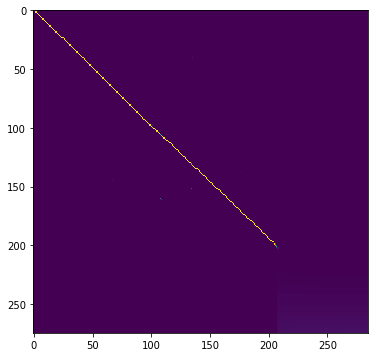

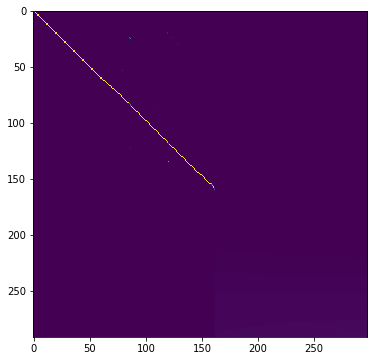

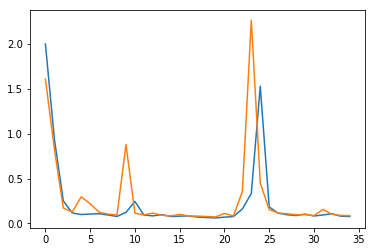

구청장은 공유단체 믿 공유기어베 대하여 서울특뼐시 과낙꾸 공유촉찌뉘원회이 시미를 거처 예사네 버뮈에서 보조금 등을 지원할 쑤 읻꼬 제도개선 등 행정적 지워늘 할 쑤 읻따.<eos>                                                                               
구청장은 공유단체 및 공유기업에 대하여 서울특별시 관악구 공유촉지ᄂ위원회의 심의를 거쳐 예산에 범위에서 보조금 등을 지원할 수 있고  제도개선 등 행정적 지원을 할 수 있다.<eos> <eos>ᄋᄋᄋᄋ                                                                           
구청장은 공유단체 및 공유기업에 대하여 서울특별시 관악구 공유촉진위원회의 심의를 거쳐 예산의 범위에서 보조금 등을 지원할 수 있고, 제도개선 등 행정적 지원을 할 수 있다.<eos>                                                                                 
통합찌원본부장은 재난현장에 신소카게 대처하기 위하여 다음 각 호에 따른 재난뉴형 등을 고려하여 현장지휘과늘 지정할 

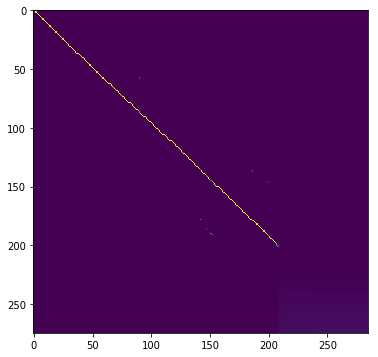

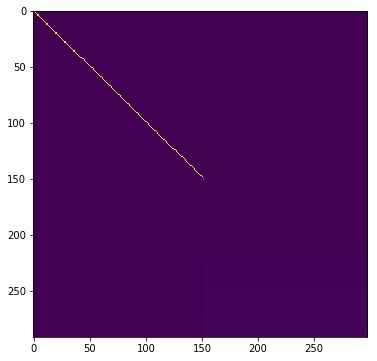

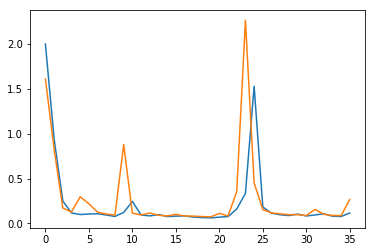

구청장은 기그메 적쩡한 지팽을 위하여 피료한 경우 기금지원사업짜에 대하여 보고를 하게 하거나 소속꽁무워느로 하여금 관계 장부나 서류를 검사하게 하는 등 피료한 조치를 할 쑤 읻따.<eos>                                                                        
구청장은 기금 ᅦ 적정한 지ᄀ앵즐 위하여 보ᄅ요한 경우 기금 ᅵ원사언아원대하여 복ᅩᆨᅳᆯ 하게 하건ᅡ 소속공무원들ᅩ 하역ᅳᆷ 관계 장분ᅡ 서로를 괌 ᅡ하게 하는 등 일요한 조치를 갈 수 있다.<eos>ᅳᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
구청장은 기금의 적정한 집행을 위하여 필요한 경우 기금지원사업자에 대하여 보고를 하게 하거나 소속공무원으로 하여금 관계 장부나 서류를 검사하게 하는 등 필요한 조치를 할 수 있다.<eos>                                                                             
시는 택시요금 민상에 따른 사전 택시업꼐 믿 택시노조 간담회를 실씨해 요그민상 배경 보카팔쯩구간 조정 등 다양하 늬겨느

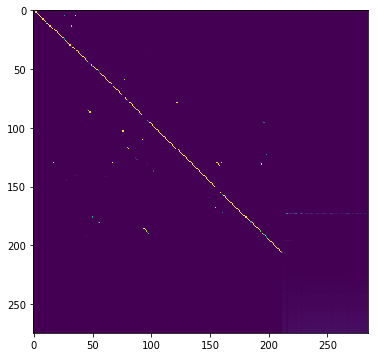

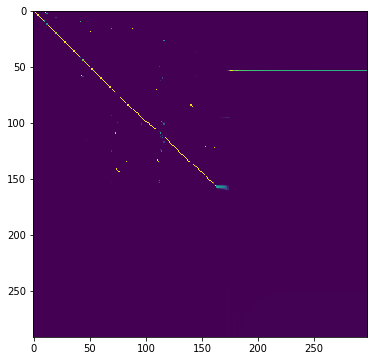

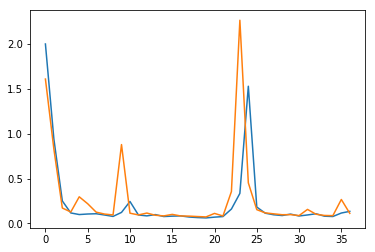

식쌩활 교유근 보육꾜지권 교육꽌계자 식품 괄련 종사자 식쌩활 괄련 단체와 소비자단체에 자발쩍 차며와 연대를 통해 가정 학꾜 지역싸회 등을 대상으로 전개되어야 한다.<eos>                                                                                 
식생활 교육근 보육교지ᄀ원  교육관계자  식품 관련 종사자  식생활 관련 잔체와 소비자단체에 잡ᅡᆯ적 참여와 연대를 통해 가정  학교  지역사회 등을 대상으로 전개되어야 한다.<eos><eos>ᄌᄒᄒᄒᄎᄎᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
식생활 교육은 보육교직원, 교육관계자, 식품 관련 종사자, 식생활 관련 단체와 소비자단체의 자발적 참여와 연대를 통해 가정, 학교, 지역사회 등을 대상으로 전개되어야 한다.<eos>                                                                                   
위원장은 혀비회를 대표하고 혀비회에 엄무를 총괄하며 위원장이 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 징무를 ᄃ

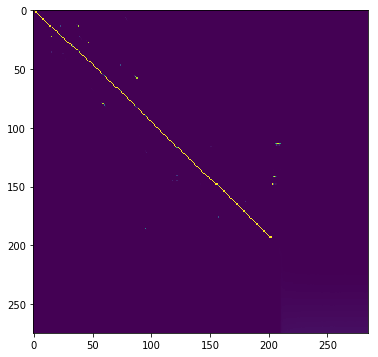

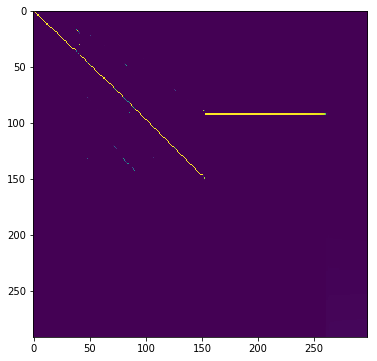

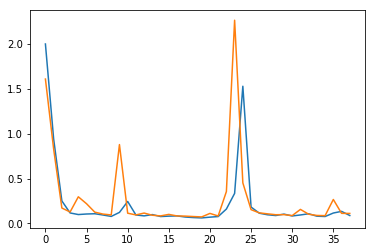

러일 전쟁에서 승니한 닐보는 한반도에 대하 누월쩍 지위를 행사하여 대한제구게 외교꿔늘 박탈하느 늘사능냐글 강제 체결한 뒤 자신드레 싱민지로 만드는 자거베 매진하엳따.<eos>                                                                                 
러일 전쟁의서 승리한 일본은 한반도에 대한 우원적 지위를 행사하여  대한제국에 외교?ᅯᆫ을 박할하는 을사능냑을 강제 체결한 뒤 자신들에 식민지로 만드는 작업에 매진하였다.<eos><eos>ᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌᄌ
러일 전쟁에서 승리한 일본은 한반도에 대한 우월적 지위를 행사하여, 대한제국의 외교권을 박탈하는 을사늑약을 강제 체결한 뒤 자신들의 식민지로 만드는 작업에 매진하였다.<eos>                                                                                 
시는 택시요금 민상에 따른 사전 택시업꼐 믿 택시노조 간담회를 실씨해 요그민상 배경 보카팔쯩구간 조정 등 다양하 늬

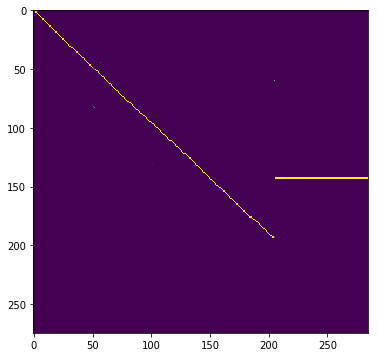

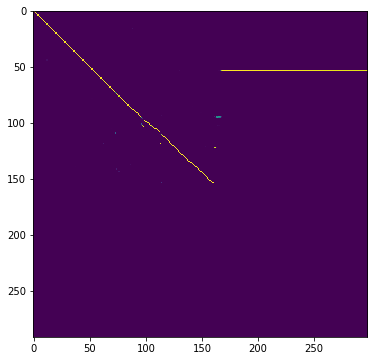

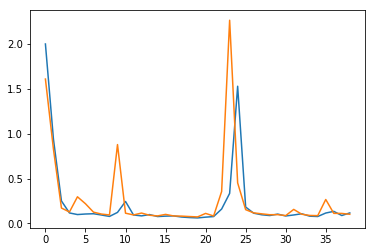

구청장은 공유단체 믿 공유기어베 대하여 서울특뼐시 과낙꾸 공유촉찌뉘원회이 시미를 거처 예사네 버뮈에서 보조금 등을 지원할 쑤 읻꼬 제도개선 등 행정적 지워늘 할 쑤 읻따.<eos>                                                                               
구청장은 공유단체 및 공유기업에 대하여 서울특별시 관악구 공유촉진위원회의 심이를 거쳐 예산에 범위에서 보조금 등을 지원할 수 있고  제독ᅢ선 등 행정적 지원을 할 수 있가.<eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
구청장은 공유단체 및 공유기업에 대하여 서울특별시 관악구 공유촉진위원회의 심의를 거쳐 예산의 범위에서 보조금 등을 지원할 수 있고, 제도개선 등 행정적 지원을 할 수 있다.<eos>                                                                                 
위원장은 위원회를 대표하고 위원회에 엄무를 총괄하며 위원장이 그 징무를 수행할 쑤 엄는 경우에는 부위원장이 그 ᄌ

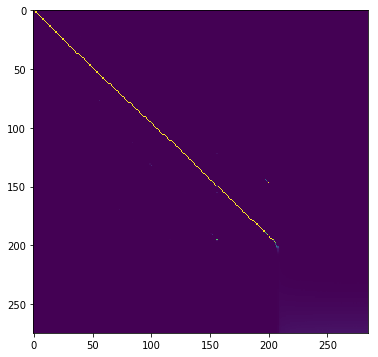

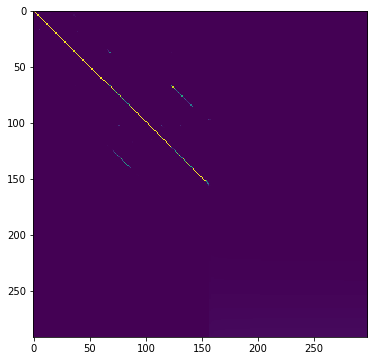

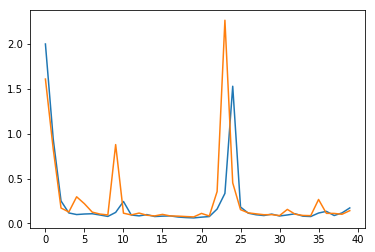

헌장부서에 장은 피료하다고 인정하는 경우에는 고개게 요구사항과 서비스를 제공하는 담당공무워네 애로사항 믿 개서니겨늘 바녕하여 헌장을 개정하는 등에 피료한 조치를 하여야 한다.<eos>                                                                        
헌장부서의 장은 필요하다고 인정하는 경우에는 고객에 요구사항 ᅪ 서비스를 제공하는 감당공무원에 애로사항 및 개선이 ᅧᄂ을 반영하여 헌장을 개정아는 긍에 필요한 조치를 자여야 한다.<eos><eos><eos>ᄀᄀᄀᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
헌장부서의 장은 필요하다고 인정하는 경우에는 고객의 요구사항과 서비스를 제공하는 담당공무원의 애로사항 및 개선의견을 반영하여 헌장을 개정하는 등의 필요한 조치를 하여야 한다.<eos>                                                                           
서산 지여근 어촌 농촌 산촌 등 다양한 지역쩍 특썽을 보이고 이쓰며 이러한 생활 모스블 바녕한 노리 문화도 고루 바

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'eumun-to-eumjul'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    train_batch_loader.initialize_batch()
    loss_list_train = list()
    
    while train_batch_loader.end_flag == False:
        eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()
        pred_tensor, attention_tensor, loss = net.train(eumun_batch.to(device), eumjul_batch.to(device), eumun_loss_mask.to(device))        
        loss_list_train.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    eval_batch_loader.initialize_batch()
    loss_list_eval = list()
    
    while eval_batch_loader.end_flag == False:
        eumjul_batch_, eumun_batch_, eumun_loss_mask = eval_batch_loader.get_batch()
        pred_tensor_, attention_tensor_, loss = net.evaluate(eumun_batch_.to(device), eumjul_batch_.to(device), eumun_loss_mask.to(device))        
        loss_list_eval.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    plt.figure()
    plt.plot(loss_history_train)
    plt.plot(loss_history_eval)
    plt.show()
    
    sentence = tokenizer.num2word(eumun_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor[0].detach().cpu().numpy())
    plt.show
    
    sentence = tokenizer.num2word(eumun_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor_[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor_[0].detach().cpu().numpy())
    plt.show

    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    

    print("-------------------------------------------------------------------------------------------------------")